In [2]:
using SDDP, Statistics, Xpress, Gurobi
using PyPlot, Random, LinearAlgebra

┌ Info: Xpress: Found license file C:\xpressmp\bin\xpauth.xpr
└ @ Xpress C:\Users\rafabench\.julia\packages\Xpress\r6dU3\src\license.jl:42
┌ Info: Xpress: Development license detected.
└ @ Xpress C:\Users\rafabench\.julia\packages\Xpress\r6dU3\src\license.jl:84


In [3]:
xpress = () -> Xpress.Optimizer(OUTPUTLOG = 0)
xpress_debug = () -> Xpress.Optimizer()

#15 (generic function with 1 method)

In [4]:
const GRB_ENV = Gurobi.Env()
gurobi = () -> Gurobi.Optimizer(GRB_ENV)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


#17 (generic function with 1 method)

In [5]:
include("../src/revenue_function.jl")

conv_func (generic function with 1 method)

#### Build Tree

In [6]:
function build_indices_stage(T,S)
    a = (1,)
    for t in 1:T-1
        a = (a...,S)
    end
    arr = []
    foreach(x->push!(arr,Tuple(x)),CartesianIndices(a))
    return arr
end

build_indices_stage (generic function with 1 method)

In [7]:
childs(node,S) = [(node...,s) for s in 1:S]

childs (generic function with 1 method)

In [8]:
parent(node) = node[1:end-1]

parent (generic function with 1 method)

#### Create multistage models

In [127]:
function cost_model(optimizer)
    
    model = Model(optimizer)
    
    # Operator
    T = model[:T] = 4
    
    C = [20.0,30.0,20.0,15.0,8.0]
    G_max = [30.0,25.0,20.0,10.0,5.0]
    ρ = [1.0,1.0]
    v_max = 200.0
    D = sum(G_max)
    K = length(G_max)
    nagents = 2
    
    # Scenario generation
    Ω = model[:Ω] = collect(0.6:0.1:1.0).*D
    S = model[:S] = length(Ω)
    idxs = build_indices_stage.(1:T,S)
    idxs_vol = build_indices_stage.(1:T+1,S)
    a = [10,2,10,2,10,2]
    
    
    v = model[:v] = []
    e = model[:e] = []
    θ = model[:θ] = []
    gh = model[:gh] = []
    gt = model[:gt] = []
    spill = model[:spill] = []
    stage = 1
    @variable(model, objective_stage[1:T], base_name="obj_$stage", lower_bound = 0)
    for idx in idxs_vol
        push!(v,
            @variable(model, [i in idx, a in 1:nagents], base_name="v_$stage", lower_bound = 0, upper_bound =  v_max))
        stage += 1
    end
    stage = 1
    for idx in idxs
        push!(e,@variable(model, [i in idx], base_name="e_$stage", lower_bound = 0))
        push!(θ,@variable(model, [i in idx], base_name="θ_$stage", lower_bound = 0))
        push!(gh,@variable(model, [i in idx, a in 1:nagents], base_name="gh_$stage", lower_bound = 0))
        push!(gt,@variable(model, [i in idx, g in 1:K], base_name="gt_$stage", lower_bound = 0))
        push!(spill,@variable(model, [i in idx, a in 1:nagents], base_name="spill_$stage", lower_bound = 0))
        stage += 1
    end
    
    for g in 1:2
        @constraint(model, v[1][(1,),g] == 25.0)
    end
    
    for t = 1:T
        for scen in idxs[t]
            C_t = C
            G_t = G_max
            s = scen[t]
            D_s = Ω[s]
            obj = sum(C_t[g]*gt[t][scen,g] for g in 1:K) #+ 10*sum(gh[t][scen,g]*ρ[g] for g in 1:nagents)
            @constraint(model, θ[t][scen] == obj)
            @constraint(model, e[t][scen] == D_s)
            @constraint(model, 
                sum(gh[t][scen,g]*ρ[g] for g in 1:nagents) + sum(gt[t][scen,g] for g in 1:K) == e[t][scen])
            
            for g in 1:K
                @constraint(model, gt[t][scen,g] <= G_t[g])
            end
            child_nodes = childs(scen,S)
            for node in child_nodes
                for g in 1:nagents
                    @constraint(model, v[t+1][node,g] == v[t][scen,g] + a[t] - gh[t][scen,g] - spill[t][scen,g])
                end
            end
        end
        @constraint(model, objective_stage[t] == 1/length(idxs[t]).*sum([θ[t]...]))
    end
    @objective(model, Min, sum(objective_stage));
    return model
end

cost_model (generic function with 1 method)

In [128]:
function agent_model_deterministic(bids_not_i,preco_agente_not_i,i,optimizer;
        integrality::INTEGRALITY=MIP,all_prices=false)
    
    model = Model(optimizer)
    
    # Operator
    T = model[:T] = 4
    
    C = [20.0,30.0,20.0,15.0,8.0]
    G_max = [30.0,25.0,20.0,10.0,5.0]
    ρ = 1.0
    v_max = 200.0
    D = sum(G_max)
    K = length(G_max)+1-1
    
    # Scenario generation
    Ω = model[:Ω] = collect(0.6:0.033:1.0).*D
    S = model[:S] = length(Ω)
    idxs = build_indices_stage.(1:T,S)
    idxs_vol = build_indices_stage.(1:T+1,S)
    a = [10,2,10,2,10,2]
    
    
    v = model[:v] = []
    e = model[:e] = []
    θ = model[:θ] = []
    g = model[:g] = []
    spill = model[:spill] = []
    stage = 1
    @variable(model, objective_stage[1:T], base_name="obj_$stage", lower_bound = 0)
    for idx in idxs_vol
        push!(v,@variable(model, [i in idx], base_name="v_$stage", lower_bound = 0, upper_bound =  v_max))
        stage += 1
    end
    stage = 1
    for idx in idxs
        push!(e,@variable(model, [i in idx], base_name="e_$stage", lower_bound = 0))
        push!(θ,@variable(model, [i in idx], base_name="θ_$stage", lower_bound = 0))
        push!(g,@variable(model, [i in idx], base_name="g_$stage", lower_bound = 0))
        push!(spill,@variable(model, [i in idx], base_name="spill_$stage", lower_bound = 0))
        stage += 1
    end

    @constraint(model, v[1][(1,)] == 25.0)
    
    for t = 1:T
        for (idx_scen,scen) in enumerate(idxs[t])
            if all_prices
                C_t = [C; preco_agente_not_i[t][idx_scen]]
                G_t = [G_max; bids_not_i[t][idx_scen]]
            else
                C_t = [C; preco_agente_not_i[t]]
                G_t = [G_max; bids_not_i[t]]
            end
            s = scen[t]
            D_s = Ω[s]
            obj = reward_function(G_t,C_t,D_s,e[t][scen],model; integrality = integrality)
            @constraint(model, θ[t][scen] == obj)
            @constraint(model, e[t][scen] == g[t][scen]*ρ)
            child_nodes = childs(scen,S)
            for node in child_nodes
                @constraint(model, v[t+1][node] == v[t][scen] + a[t] - g[t][scen] - spill[t][scen])
            end
        end
        @constraint(model, objective_stage[t] == 1/length(idxs[t]).*sum([θ[t]...]))
    end
    @objective(model, Max, sum(objective_stage));
    return model
end

agent_model_deterministic (generic function with 1 method)

#### Results processing

In [129]:
get_demand(node, Ω) = Ω[node[end]]

get_demand (generic function with 1 method)

In [130]:
function results(model;cost=false)
    v = Dict()
    e = Dict()
    θ = Dict()
    if !cost
        g = Dict()
    else
        gt = Dict()
        gh = Dict()
    end
    spill = Dict()
    cmo = Dict()
    T = model[:T]
    S = model[:S]
    for t in 1:T
        for scen in axes(model[:θ][t])[1]
            if !cost
                g[scen] = value(model[:g][t][scen])
                spill[scen] = value(model[:spill][t][scen])
                v[scen] = value(model[:v][t][scen])
            else
                G = last(axes(model[:gt][1])[2])
                A = last(axes(model[:gh][1])[2])
                gt[scen] = value.([model[:gt][t][scen,g] for g in 1:G])
                gh[scen] = value.([model[:gh][t][scen,g] for g in 1:A])
                spill[scen] = value.([model[:spill][t][scen,g] for g in 1:A])
                v[scen] = value.([model[:v][t][scen,g] for g in 1:A])
            end
            e[scen] = value(model[:e][t][scen])
            θ[scen] = value(model[:θ][t][scen])
            cmo[scen] = value(model[:θ][t][scen]) / value(model[:e][t][scen])
        end
        
    end
    for scen in axes(model[:v][T+1])[1]
        if !cost
            v[scen] = value(model[:v][T+1][scen])
        else
            A = last(axes(model[:gh][1])[2])
            v[scen] =  value.([model[:v][T+1][scen,g] for g in 1:A])
        end
    end
    if !cost
        data = Dict(Symbol("T") => T, Symbol("S") => S, Symbol("e") => e, Symbol("g") => g, 
            Symbol("spill") => spill, Symbol("θ") => θ, Symbol("v") => v,Symbol("cmo") => cmo)
    else
        data = Dict(Symbol("T") => T, Symbol("S") => S, Symbol("e") => e, Symbol("gt") => gt, Symbol("gh") => gh,
            Symbol("spill") => spill, Symbol("θ") => θ, Symbol("v") => v,Symbol("cmo") => cmo)
    end
    return data
end

results (generic function with 1 method)

In [131]:
get_idxs(model, t) = axes(model[:θ][t])[1]

get_idxs (generic function with 1 method)

In [132]:
filtration(leaf) = [leaf[1:t] for t in 1:length(leaf)]

filtration (generic function with 1 method)

#### Run Models

In [133]:
price_agent = [30.0,20.0,10.0,15.0]
bid_agent = [15,47,35,40]

4-element Vector{Int64}:
 15
 47
 35
 40

In [134]:
model0 = cost_model(gurobi);

In [135]:
optimize!(model0)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 2814 rows, 3282 columns and 9522 nonzeros
Model fingerprint: 0x4a5ec558
Coefficient statistics:
  Matrix range     [8e-03, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+02, 2e+02]
  RHS range        [2e+00, 9e+01]
Presolve removed 1098 rows and 537 columns
Presolve time: 0.02s
Presolved: 1716 rows, 2745 columns, 7103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.053356e+03   0.000000e+00      0s
    2144    3.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2144 iterations and 0.04 seconds
Optimal objective  3.000000000e+03

User-callback calls 2221, time in user-callback 0.00 sec


In [136]:
data0 = results(model0,cost=true);

In [139]:
model3 = agent_model_deterministic(bid_agent,price_agent,1,gurobi;integrality=LP);

In [140]:
optimize!(model3)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 62345 rows, 62345 columns and 206295 nonzeros
Model fingerprint: 0xd1a8fd37
Coefficient statistics:
  Matrix range     [5e-04, 9e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 3e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 16895 rows and 11905 columns
Presolve time: 0.25s
Presolved: 45450 rows, 50440 columns, 188383 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.731e+05
 Factor NZ  : 5.066e+05 (roughly 40 MBytes of memory)
 Factor Ops : 7.062e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.06645194e+03  3.94539304e+07  6.94e+01 2.27e+01  1.20e+03     0s
   1   1.84996713e+03  1.96153982e+07  4.42e+01 5.70e+00  4.97e+02     1s
   2   1.271203

In [141]:
data3 = results(model3);

In [142]:
model2 = agent_model_deterministic(bid_agent,price_agent,1,gurobi;integrality=CONC);

In [143]:
optimize!(model2)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 45304 rows, 45225 columns and 154863 nonzeros
Model fingerprint: 0x311e0f10
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+02, 2e+02]
  RHS range        [3e-14, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 9567 rows and 7173 columns
Presolve time: 0.14s
Presolved: 35737 rows, 38052 columns, 133159 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.168e+03
 Factor NZ  : 4.794e+03
 Factor Ops : 7.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.39401489e+04  1.46767079e+06  9.17e+02 5.93e+00  2.33e+04     0s
   1   5.02995075e+03  1.83335753e+06  3.74e+02 9.19e+00  8.94e+03     0s
   2   2.09377003e+03  1.16934308e+06  3.82e+01

In [144]:
data2 = results(model2);

In [145]:
model1 = agent_model_deterministic(bid_agent,price_agent,1,gurobi;integrality=MIP);

In [146]:
optimize!(model1)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 62345 rows, 62345 columns and 206295 nonzeros
Model fingerprint: 0xbafce45c
Variable types: 52595 continuous, 9750 integer (9750 binary)
Coefficient statistics:
  Matrix range     [5e-04, 9e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+02, 2e+02]
  RHS range        [1e+00, 3e+01]
Presolve removed 50838 rows and 52866 columns
Presolve time: 0.58s
Presolved: 11507 rows, 9479 columns, 32918 nonzeros
Variable types: 5871 continuous, 3608 integer (3608 binary)

Root relaxation: objective 9.785628e+02, 3891 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  978.56279    0  208          -  978.56279      -     -    1s
H    0     0                     977.4565089  978.56279  0.11%     -    1s
H    0     0                     977.8687301  978.56279  0.07%     -    1

In [147]:
data1 = results(model1);

In [148]:
objective_value(model0)

2999.9999999999995

In [149]:
objective_value(model1)

978.2721893491128

In [150]:
objective_value(model2)

978.5648233727793

In [151]:
objective_value(model3)

978.564823372779

#### Plot results

In [152]:
function plot_results(data, vars, leaves) 
    T = data[:T]
    S = data[:S]
    yss = []
    for var in vars
        fig = figure()
        all_leaves = ifelse(var == "v",vcat(childs.(leaves,S)...),leaves)
        for leaf in all_leaves
            ys = [data[Symbol(var)][scen] for scen in filtration(leaf)]
            push!(yss,ys)
            last = ifelse(var == "v",T+1,T)
            plt.plot(1:last, ys)
            xticks(1:last)
            grid()
        end
    end
    return yss
end

plot_results (generic function with 1 method)

In [153]:
function hist_results(data, vars, leaves) 
    T = data[:T]
    S = data[:S]
    for var in vars
        fig = figure()
        all_leaves = ifelse(var == "v",vcat(childs.(leaves,S)...),leaves)
        last = ifelse(var == "v",T+1,T)
        ys = [[data[Symbol(var)][scen] for scen in filtration(leaf)] for leaf in all_leaves]
        ys = hcat(ys...)'
        plt.hist(ys)
        plt.legend(string.(1:last))
        plt.xlabel(var)
    end
end

hist_results (generic function with 1 method)

In [164]:
idxs_vol = build_indices_stage.(1:4,5);

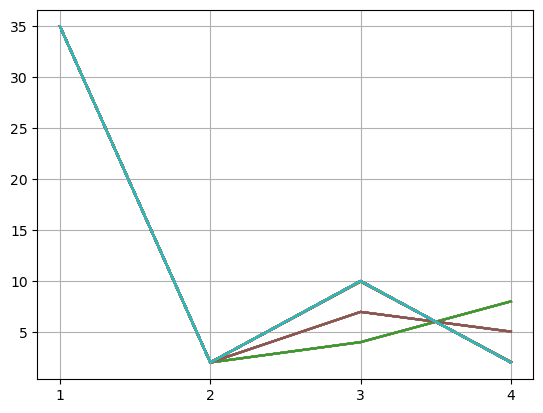

In [155]:
yss = plot_results(data1,["e"], idxs_vol[4][1:100])
grid()

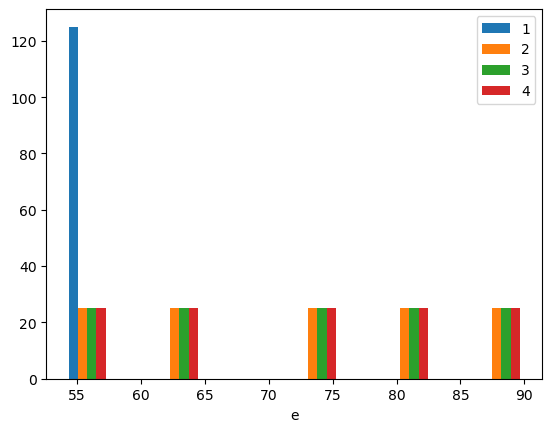

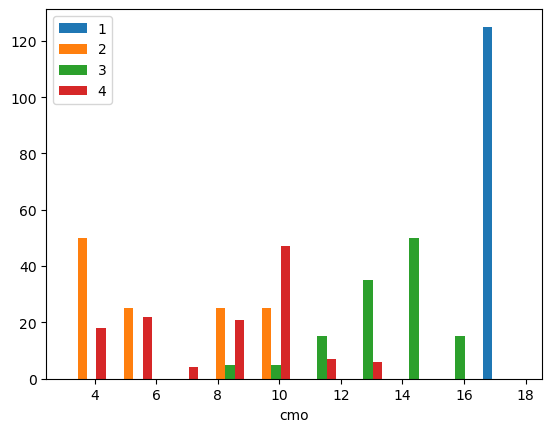

In [168]:
hist_results(data0,["e","cmo"], idxs_vol[4])

#### Convergence to Nash Equilibria

In [169]:
preco_agent = [20.0,20.0,20.0,15.0]
bid_agent = [24.0, 38.0, 3.0, 9.0]

4-element Vector{Float64}:
 24.0
 38.0
  3.0
  9.0

In [170]:
preco_agent = [30.0,20.0,10.0,15.0]
bid_agent = [15,47,35,40]

4-element Vector{Int64}:
 15
 47
 35
 40

In [171]:
function pretty_print(string)
    println('-'^60)
    println(string)
    println('-'^60)
end

pretty_print (generic function with 1 method)

In [107]:
preco_agent = [30.0,20.0,10.0,15.0]
bid_agent = [15,47,35,40]
all_prices = false
for iter in 1:2
    pretty_print("Iter = $iter")
    for agent in 1:2
        println("Agent = $agent")
        model3 = agent_model_deterministic(bid_agent,preco_agent,agent,xpress;integrality=MIP,all_prices=all_prices);
        set_time_limit_sec(model3, 60.0)
        set_silent(model3)
        optimize!(model3)
        data3 = results(model3); 
        bid_agent = [[data3[:e][node] for node in nodes_t] for nodes_t in idxs_vol]
        preco_agent = [[data3[:cmo][node] for node in nodes_t] for nodes_t in idxs_vol]
        @show mean.(bid_agent)
        @show mean.(preco_agent)
        @show var.(bid_agent)
        @show var.(preco_agent)
        println()
        all_prices = true
    end
end

------------------------------------------------------------
Iter = 1
------------------------------------------------------------
Agent = 1
mean.(bid_agent) = [27.269999999999996, 34.73000000000001, 9.07, 2.917633136094674]
mean.(preco_agent) = [19.999999999999996, 20.0, 20.0, 19.171597633136095]
var.(bid_agent) = [NaN, 3.7865323450608567e-29, 4.265300000000002, 4.117495761524451]
var.(preco_agent) = [NaN, 4.2072581611787294e-30, 0.0, 3.457335014712063]

Agent = 2
mean.(bid_agent) = [17.329999999999984, 24.425384615384626, 10.934556213017759, 17.364274010013656]
mean.(preco_agent) = [19.999999999999993, 20.0, NaN, 23.923532089212564]
var.(bid_agent) = [NaN, 57.722893589743734, 40.29814756973796, 43.75123377370036]
var.(preco_agent) = [NaN, 1.0518145402946823e-30, NaN, 23.852073493163807]

------------------------------------------------------------
Iter = 2
------------------------------------------------------------
Agent = 1
mean.(bid_agent) = [30.60000000000001, 8.314615384615383, 